# MVP model: Feature Integration & Model Comparison

The general idea of this final notebook is to integrate all the features engineered through the notebooks 02 to 05. 

We aim to understand which fount and features where the most importantes and the possible reasons  of this.

## 0) Imports

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)


In [5]:
def unify(df_base, df_temp, df_tmdb, genome) -> pd.DataFrame:
    df = df_base.copy()

    dup_cols = [c for c in df_temp.columns if c in df.columns and c not in ["userId","movieId"]]
    df_temp = df_temp.drop(columns=dup_cols)

    df = df.merge(df_temp, on=["userId","movieId"], how="left")
    dup_cols = [c for c in df_tmdb.columns if c in df.columns and c not in ["userId","movieId"]]
    df_tmdb = df_tmdb.drop(columns=dup_cols)

    df = df.merge(df_tmdb, on=["userId","movieId"], how="left")
    df = df.merge(genome_pca, on="movieId", how="left")

    return df

## 1) Load feature datasets

In [7]:
# baseline
train_b = pd.read_parquet("../data/processed/train_prepared.parquet")
val_b   = pd.read_parquet("../data/processed/val_prepared.parquet")
test_b  = pd.read_parquet("../data/processed/test_prepared.parquet")

# temporal v2
train_t = pd.read_parquet("../data/processed/train_prepared_v2_temporal.parquet")
val_t   = pd.read_parquet("../data/processed/val_prepared_v2_temporal.parquet")
test_t  = pd.read_parquet("../data/processed/test_prepared_v2_temporal.parquet")

# tmdb v3
train_tm = pd.read_parquet("../data/processed/train_prepared_v3_tmdb.parquet")
val_tm   = pd.read_parquet("../data/processed/val_prepared_v3_tmdb.parquet")
test_tm  = pd.read_parquet("../data/processed/test_prepared_v3_tmdb.parquet")

# genome PCA (movie-level, keyed by movieId)
genome_pca = pd.read_parquet("../data/processed/genome_pca_50.parquet")  # columns: movieId + pca_0 .. pca_49


In [8]:
train_u = unify(train_b, train_t, train_tm, genome_pca)
val_u = unify(val_b, val_t, val_tm, genome_pca)
test_u = unify(test_b, test_t, test_tm, genome_pca)

In [9]:
train_u.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'timestamp_dt',
       'high_rating', 'user_mean_rating', 'user_like_rate', 'user_n_ratings',
       'movie_mean_rating',
       ...
       'gen_pca_40', 'gen_pca_41', 'gen_pca_42', 'gen_pca_43', 'gen_pca_44',
       'gen_pca_45', 'gen_pca_46', 'gen_pca_47', 'gen_pca_48', 'gen_pca_49'],
      dtype='str', length=201)

## 2) Select feature set

In order to keep things simple, we are not going to propose an intrincate feature selection pipeline. In other scenarios, it would be recomendable to run at least two squencial steps:

- Univariate analysis: nulls values, unique, IV
- Multivariate analysys: shap values, boruta, correlations (pearson, chi2)

 But for now, lets use the preliminar results of the feature importance of the baseline model and the PCA model in order to filter some features.

In [12]:
feature_cols = [
    'user_mean_rating','user_like_rate','user_n_ratings',
    'user_rating_ewm','user_like_ewm','user_lastN_mean','user_lastN_like',
    'movie_mean_rating','movie_like_rate','movie_n_ratings',
    'movie_rating_ewm','movie_like_ewm','movie_pop_ewm','movie_trend_ewm',
    'log1p_budget','log1p_revenue','adult','tmdb_has_budget','tmdb_has_revenue','tmdb_has_adult',
    'gen_pca_0' ,'year', 'gen_pca_2' ,'gen_pca_23' ,'gen_pca_11' 
]

X_train = train_u[feature_cols]
y_train = train_u['high_rating']
X_val = val_u[feature_cols]
y_val = val_u['high_rating']
X_test = test_u[feature_cols]
y_test = test_u['high_rating']
(X_train.shape, X_val.shape, X_test.shape)

((4490259, 25), (599327, 25), (846774, 25))

## 3) Train simple XGBoost

In [14]:
X_train = X_train.astype("float32").fillna(np.nan)
X_val = X_val.astype("float32").fillna(np.nan)
X_test = X_test.astype("float32").fillna(np.nan)

In [15]:
model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    tree_method='hist'
)
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

### 3.2) Baseline Model

In [29]:
BASELINE_PATH = "../artifacts/baseline_xgb_model.pkl"
with open(BASELINE_PATH, "rb") as f:
    baseline_model = pickle.load(f)
type(baseline_model)

xgboost.sklearn.XGBClassifier

In [34]:
metadata = ['userId', 'movieId', 'rating', 'timestamp', 'timestamp_dt', 'high_rating']

In [38]:
X_test_base = test_b[[f for f in test_b.columns if f not in metadata]]
y_test_base = test_b['high_rating']
X_test_base = X_test_base.astype("float32").fillna(np.nan)

In [39]:
test_proba_base = baseline_model.predict_proba(X_test_base)[:, 1]

## 4) Evaluate (ROC AUC, PR-AUC) + plot curves
- **ROC AUC**: ranking quality across thresholds.
- **PR-AUC (Average Precision)**: more informative than ROC AUC when classes are imbalanced.
- **F1 @ 0.5**: a quick operating-point metric (we may later choose a better threshold).


In [40]:
def metrics(y_true, p, thr=0.5):
    return {
        "roc_auc": roc_auc_score(y_true, p),
        "pr_auc": average_precision_score(y_true, p),
        "f1@0.5": f1_score(y_true, (p >= thr).astype(int)),
    }


In [41]:
m_base = metrics(y_test_base, test_proba_base)
m_new  = metrics(y_test, test_proba)

pd.DataFrame([m_base, m_new], index=["baseline", "new_model"])

,roc_auc,pr_auc,f1@0.5
baseline,0.813073,0.811254,0.749153
new_model,0.830562,0.828151,0.761328


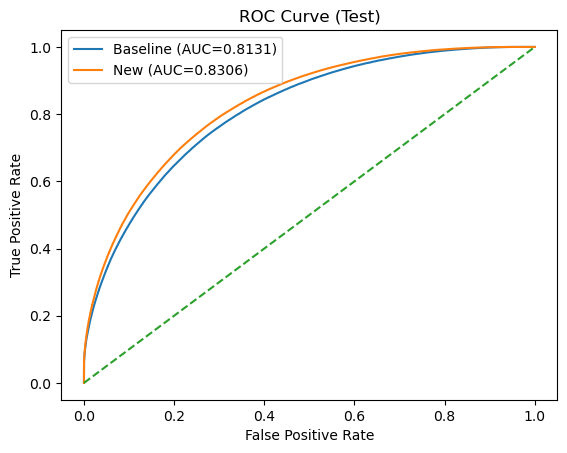

In [44]:
fpr_b, tpr_b, _ = roc_curve(y_test_base, test_proba_base)
fpr_n, tpr_n, _ = roc_curve(y_test, test_proba)

plt.figure()
plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={m_base['roc_auc']:.4f})")
plt.plot(fpr_n, tpr_n, label=f"New (AUC={m_new['roc_auc']:.4f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()


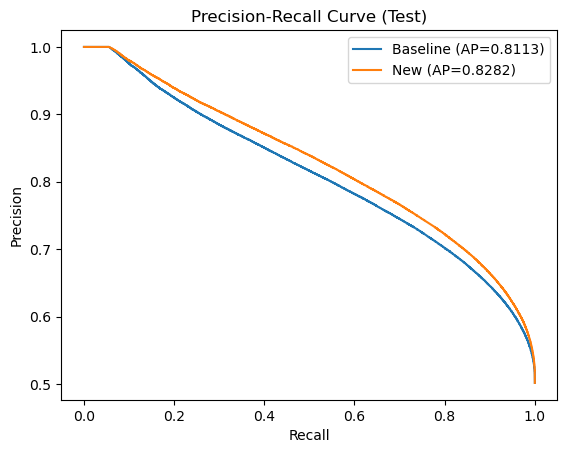

In [47]:
prec_b, rec_b, _ = precision_recall_curve(y_test_base, test_proba_base)
prec_n, rec_n, _ = precision_recall_curve(y_test, test_proba)

plt.figure()
plt.plot(rec_b, prec_b, label=f"Baseline (AP={m_base['pr_auc']:.4f})")
plt.plot(rec_n, prec_n, label=f"New (AP={m_new['pr_auc']:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.show()


## 5) Feature Importance: some final conclusions


In [48]:
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
importances

user_like_ewm        0.223390
movie_like_rate      0.160529
user_rating_ewm      0.153866
user_like_rate       0.142419
movie_mean_rating    0.142034
user_mean_rating     0.042999
user_lastN_like      0.025180
movie_like_ewm       0.017970
gen_pca_0            0.013779
movie_rating_ewm     0.011951
user_lastN_mean      0.010874
user_n_ratings       0.009576
year                 0.008163
movie_n_ratings      0.007130
log1p_revenue        0.006788
gen_pca_2            0.004475
gen_pca_23           0.003858
gen_pca_11           0.003829
tmdb_has_budget      0.003150
log1p_budget         0.002857
adult                0.002403
tmdb_has_adult       0.001409
movie_trend_ewm      0.001369
tmdb_has_revenue     0.000000
movie_pop_ewm        0.000000
dtype: float32

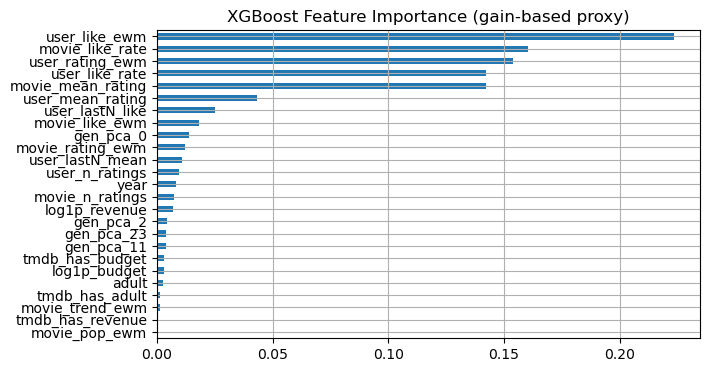

In [49]:
plt.figure(figsize=(7, 4))
importances.sort_values().plot(kind="barh")
plt.title("XGBoost Feature Importance (gain-based proxy)")
plt.grid(True)
plt.show()


### Feature Importance — Some insights on what this means

### 1) **user_like_ewm**
Captures the user’s *recent* tendency to give high ratings.  
Strongest predictor: short-term preference shifts dominate long-term history.
This is useful, cause it give us a more realistic view of how a user tned to behavie un recent time.
But this feature has a drawback: cold start. But as we know, in this dataset there are no user with no reviews (minimun is 20)

### 2) **movie_like_rate**
Measures how often the movie is generally liked.  
High global consensus strongly increases the probability of a new “high” rating.
This allow us to use the information of other users. It is a common feature in all recomendation sistems. 
The fact that the first two features combine differnt sources is a good signal.

### 3) **user_rating_ewm**
Decay-weighted mean rating of the user.  
Reflects current “mood” or rating intensity better than long-run averages.
We should see how this feature correlates with historical rating.

### 4) **user_like_rate**
Long-term proportion of high ratings.  
Provides a stable baseline for how optimistic or strict the user is.
This feature can leverage the information of the user_like_ewm when we have some bias because of recent behaviour.

### 5) **movie_mean_rating**
Overall average rating of the movie.  
Captures perceived quality; consistent boost for well-rated titles.
Again, this might be correlated with movie_like_rate.

### 6) **user_mean_rating**
Long-run user rating level.  
Weaker than EWM but helps anchor predictions for users with stable behavior.

### 7) **user_lastN_like**
Short-window like rate.  
Models micro-trends in user behavior that EWM alone doesn’t capture.

### 8) **movie_like_ewm**
Recent like rate for the movie.  
Useful for temporal popularity spikes or rediscovered movies.

### 9) **gen_pca_0**
Strongest latent semantic factor from Genome.  
Adds fine-grained content signal not captured by genres or ratings.

### 10) **movie_rating_ewm**
Decay-weighted movie rating average.  
Provides a time-sensitive version of movie quality, improving recency alignment.


### TOP INSIGHT: 

We can see that the prevalent features of the dataset are mostly the engineered. Thus we could construct a completly new model with better perfomance relying on new processed information rather than the mos common features. 

This can be used as a real baseline for further developments on new and more complex features.


## ON LINE MODEL CONSISDERATIONS

Most of these features cna be obteined throgh common calcualtions, via API in real time.

**But we have to be careful with external sources** We do not control the source of infomration, and thins like table atualization and freshness are out of our control. So we highly recommend to use data from at leat one month earlier, when calculating features for training and when using them in production, **just to avoid leakage**.

**Its also importante estimate the times for actualization of user based tables and mmovie based tables in pur own datalakes**

